In [1]:
from keras.models import load_model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2023-08-15 01:44:07.405293: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 01:44:07.437911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
Z_DIM = 100

vector_keygen = lambda: np.random.uniform(-1, 1, size=(Z_DIM,))
sign_swap = lambda x, k: x * np.sign(k)
modulo_add = lambda x, k: (x + k) % 2 - 1
modulo_sub = lambda x, k: (x - k) % 2 - 1
multiply = lambda x, k: x * k
divide = lambda x, k: x / k

scalar_keygen = lambda: np.random.uniform(-1, 1)
shift_forward = lambda x, k: np.roll(x, int(k * x.shape[1]), axis=1)
shift_backward = lambda x, k: np.roll(x, -int(k * x.shape[1]), axis=1)

keygen = vector_keygen
encrypt = sign_swap
decrypt = sign_swap

In [3]:
generator = load_model("generator.h5")
encoder = load_model("encoder.h5")

2023-08-15 01:44:09.157083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2208 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
RESULTS = 6

key = keygen()
alt_key = keygen()
pto_images = mnist.load_data()[0][0]
pto_images = pto_images[np.random.randint(0, pto_images.shape[0], size=RESULTS)]
pto_images = (pto_images.astype(np.float32) - 127.5) / 127.5

pto = encoder(pto_images)
cto = encrypt(pto, key)
cto_images = generator(cto)
alt_cto = encrypt(pto, alt_key)
alt_cto_images = generator(alt_cto)
ctr = encoder(cto_images)
ptr = decrypt(ctr, key)
ptr_images = generator(ptr)
ptw = decrypt(ctr, alt_key)
ptw_images = generator(ptw)

2023-08-15 01:44:09.601711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-08-15 01:44:09.662138: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-15 01:44:09.815259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


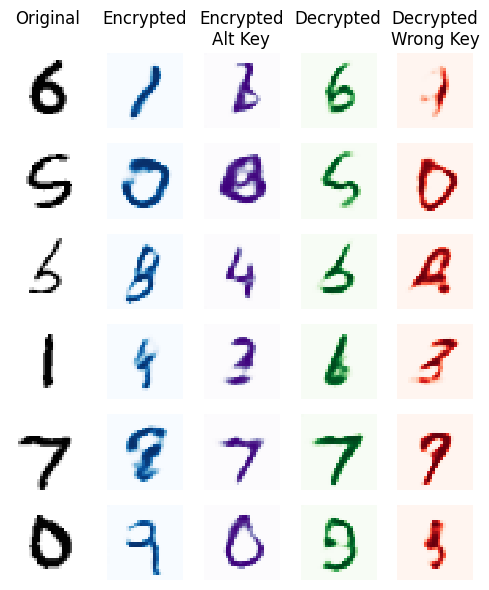

In [5]:
plt.figure(figsize=(5, RESULTS))
cols = ["Original\n", "Encrypted\n", "Encrypted\nAlt Key", "Decrypted\n", "Decrypted\nWrong Key"]
for i in range(RESULTS):
    plt.subplot(RESULTS, 5, 5*i + 1)
    plt.imshow(pto_images[i], cmap="Greys", interpolation="nearest")
    plt.axis("off")
    if i == 0: plt.title(cols[0])
    plt.subplot(RESULTS, 5, 5*i + 2)
    plt.imshow(cto_images[i], cmap="Blues", interpolation="nearest")
    plt.axis("off")
    if i == 0: plt.title(cols[1])
    plt.subplot(RESULTS, 5, 5*i + 3)
    plt.imshow(alt_cto_images[i], cmap="Purples", interpolation="nearest")
    plt.axis("off")
    if i == 0: plt.title(cols[2])
    plt.subplot(RESULTS, 5, 5*i + 4)
    plt.imshow(ptr_images[i], cmap="Greens", interpolation="nearest")
    plt.axis("off")
    if i == 0: plt.title(cols[3])
    plt.subplot(RESULTS, 5, 5*i + 5)
    plt.imshow(ptw_images[i], cmap="Reds", interpolation="nearest")
    plt.axis("off")
    if i == 0: plt.title(cols[4])
plt.tight_layout()
plt.savefig("results.png")
plt.show()